In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import dataset
df = pd.read_csv('./dataset/230322_OlderPredictTc_data_thermal.csv')

print("Number unique participants before exclustion:", len(df['id_all'].unique()))

# Select only time > 0
df = df[df.time > 0]
# Select only people >= 60
df = df[df.age >= 60]

# Remove ID 26 (id_all = 93) from heatwave 2 (hot) due to incomplete data (only ran until 469 minutes instead of full 480)
condition_mask = (df['study'] == 'heatwave 2 (indoor)') & (df['condition'] == 'hot')
df = df[~((df['id'] == 26) & condition_mask)]

print("Number unique participants after exclustion:", len(df['id_all'].unique()))

Number unique participants before exclustion: 96
Number unique participants after exclustion: 76


In [34]:
from sklearn.model_selection import train_test_split

# Get unique 'id_all' values
unique_ids = df['id_all'].unique()

# Split 'id_all' into training and testing groups with a 60/40 ratio
# Seed random number 1-1,000,000
train_ids, test_ids = train_test_split(unique_ids, test_size=0.4)

# Create train and test dataframes based on 'id_all'
train_data = df[df['id_all'].isin(train_ids)]
test_data = df[df['id_all'].isin(test_ids)]

In [38]:
train_ids, test_ids

(array([46, 34, 68, 30, 40, 98, 89, 65, 24, 58, 85, 67, 28, 39, 35, 77, 26,
        80, 70, 37, 52, 56, 74, 78, 71, 60, 86, 43, 91, 82, 22, 59, 21, 87,
        95, 66, 44, 25, 76, 94, 53, 32, 73, 23, 49]),
 array([61, 97, 50, 83, 81, 75, 96, 36, 72, 62, 27, 84, 63, 69, 79, 42, 92,
        88, 33, 55, 64, 54, 93, 45, 29, 47, 48, 38, 57, 90, 41]))

In [2]:
train_ids = [46, 34, 68, 30, 40, 98, 89, 65, 24, 58, 85, 67, 28, 39, 35, 77, 26,
        80, 70, 37, 52, 56, 74, 78, 71, 60, 86, 43, 91, 82, 22, 59, 21, 87,
        95, 66, 44, 25, 76, 94, 53, 32, 73, 23, 49]

test_ids = [61, 97, 50, 83, 81, 75, 96, 36, 72, 62, 27, 84, 63, 69, 79, 42, 92,
        88, 33, 55, 64, 54, 93, 45, 29, 47, 48, 38, 57, 90, 41]

train_ids.sort()
test_ids.sort()
print(train_ids)

print(test_ids)

train_data = df[df['id_all'].isin(train_ids)]
test_data = df[df['id_all'].isin(test_ids)]

[21, 22, 23, 24, 25, 26, 28, 30, 32, 34, 35, 37, 39, 40, 43, 44, 46, 49, 52, 53, 56, 58, 59, 60, 65, 66, 67, 68, 70, 71, 73, 74, 76, 77, 78, 80, 82, 85, 86, 87, 89, 91, 94, 95, 98]
[27, 29, 33, 36, 38, 41, 42, 45, 47, 48, 50, 54, 55, 57, 61, 62, 63, 64, 69, 72, 75, 79, 81, 83, 84, 88, 90, 92, 93, 96, 97]


In [44]:
# Count unique 'id_all' for each 'study'-'condition' combination in training and testing sets
train_counts = train_data.groupby(['study', 'condition'])['id_all'].nunique()
test_counts = test_data.groupby(['study', 'condition'])['id_all'].nunique()

# Calculate total unique 'id_all' for each 'study'-'condition' combination
total_counts = df.groupby(['study', 'condition'])['id_all'].nunique()

# Calculate proportions
train_proportions = train_counts / total_counts
test_proportions = test_counts / total_counts

# Combine results into a single DataFrame
result = pd.concat([train_counts, train_proportions, test_counts, test_proportions], axis=1)
result.columns = ['Train Count', 'Train Proportion', 'Test Count', 'Test Proportion']

result

Train Count  Train Proportion  Test Count  \
study                  condition                                              
heatwave 1 (prolonged) hot                 26          0.666667          13   
heatwave 2 (indoor)    cool                 8          0.500000           8   
                       hot                 22          0.628571          13   
                       temp                 8          0.500000           8   
                       warm                22          0.594595          15   
heatwave 3 (cooling)   hot                 10          0.526316           9   

                                  Test Proportion  
study                  condition                   
heatwave 1 (prolonged) hot               0.333333  
heatwave 2 (indoor)    cool              0.500000  
                       hot               0.371429  
                       temp              0.500000  
                       warm              0.405405  
heatwave 3 (cooling)   hot               0.473684

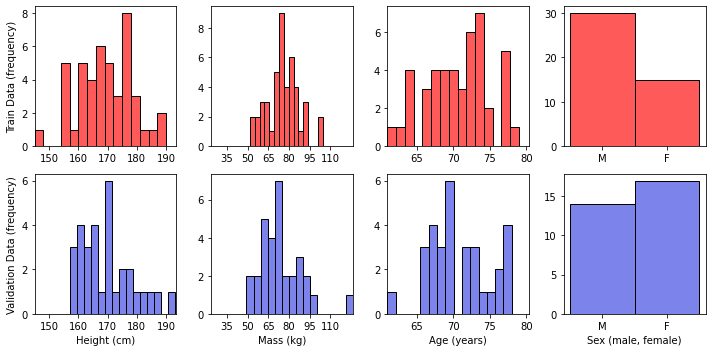

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

# sns.set(style="whitegrid")
colors = ['#87CC94', '#25CB00', '#FF9999', '#FF5A5A', '#7c84eb', '#0313fc']

# Remove duplicates based on 'id_all' column
train_dist = train_data.drop_duplicates(subset='id_all')
test_dist = test_data.drop_duplicates(subset='id_all')

fig, axs = plt.subplots(2, 4, figsize=(10, 5)) # create 2x4 subplots

variables = ['height', 'mass', 'age', 'female'] # variables to plot
labels = ['Height (cm)', 'Mass (kg)', 'Age (years)', 'Sex (male, female)'] # labels to plot

# Set common labels
axs[0, 0].set_ylabel('Train Data (frequency)')
axs[1, 0].set_ylabel('Validation Data (frequency)')

for i, var in enumerate(variables):
    if var == 'female':
        bins = 2
    else:
        bins = 15

    # Train data histogram
    axs[0, i].hist(train_dist[var], bins=bins, color=colors[3], alpha=1, edgecolor='black')
    # Validation data histogram
    axs[1, i].hist(test_dist[var], bins=bins, color=colors[4], alpha=1, edgecolor='black')

    # Set x labels
    axs[1, i].set_xlabel(labels[i])

    # Set x limits
    if var != 'female':
        combined_dist = pd.concat([train_dist, test_dist])
        mean = combined_dist[var].mean()
        lowest_value = min(combined_dist[var])
        highest_value = max(combined_dist[var])
        max_distance_to_mean = max(math.fabs(mean - lowest_value), math.fabs(mean - highest_value))
        axs[0, i].set_xlim(mean - max_distance_to_mean, mean + max_distance_to_mean)
        axs[1, i].set_xlim(mean - max_distance_to_mean, mean + max_distance_to_mean)

    # Set x ticks
    if var == 'height':
        axs[0, i].set_xticks([150, 160, 170, 180, 190])
        axs[1, i].set_xticks([150, 160, 170, 180, 190])
    if var == 'mass':
        axs[0, i].set_xticks([35, 50, 65, 80, 95, 110])
        axs[1, i].set_xticks([35, 50, 65, 80, 95, 110])
    if var == 'female':
        axs[0, i].set_xticks([0.25, 0.75])
        axs[0, i].set_xticklabels(['M', 'F'])
        axs[1, i].set_xticks([0.25, 0.75])
        axs[1, i].set_xticklabels(['M', 'F'])

# Center the plots
for ax_row in axs:
    for ax in ax_row:
        ax.set_xlim(ax.get_xlim())

plt.tight_layout()
plt.savefig("figures/data_distribution.pdf", format='pdf')
plt.show()

# Stratified sampling (obsolete)

In [22]:
from sklearn.model_selection import train_test_split

# Group by 'study' and 'condition'
grouped = df.groupby(['study', 'condition'])

# Initialize an empty dictionary to store the results
splits = {}

# For each group
for (study, condition), group in grouped:
    # Get unique 'id_all'
    unique_ids = group['id_all'].unique()

    # Split into train and test
    # Random number selected between 1->1,000,000
    train_ids, test_ids = train_test_split(unique_ids, test_size=0.4)

    # Store the results
    splits[(study, condition)] = {
        'train': train_ids.tolist(),
        'test': test_ids.tolist()
    }

# Convert the splits dictionary to a DataFrame
splits_df = pd.DataFrame.from_dict(splits, orient='index')

# Optional: reset the index to have 'study' and 'condition' as columns instead of index
splits_df.reset_index(inplace=True)
splits_df.columns = ['study', 'condition', 'train', 'test']

splits_df


,study,condition,train,test
0,heatwave 1 (prolonged),hot,"[69, 80, 72, 64, 36, 66, 68, 63, 62, 37, 21, 3...","[77, 65, 24, 74, 71, 23, 61, 76, 40, 33, 79, 3..."
1,heatwave 2 (indoor),cool,"[46, 57, 29, 53, 55, 26, 83, 48, 84]","[85, 82, 86, 23, 24, 81, 41]"
2,heatwave 2 (indoor),hot,"[57, 93, 29, 84, 41, 98, 75, 95, 87, 89, 77, 2...","[86, 82, 83, 53, 74, 65, 24, 67, 78, 94, 90, 4..."
3,heatwave 2 (indoor),temp,"[82, 41, 53, 26, 83, 55, 81, 24, 48]","[85, 29, 57, 23, 86, 84, 46]"
4,heatwave 2 (indoor),warm,"[24, 87, 92, 91, 23, 84, 55, 96, 90, 78, 85, 8...","[83, 53, 68, 74, 98, 46, 29, 89, 65, 94, 41, 9..."
5,heatwave 3 (cooling),hot,"[55, 56, 41, 59, 43, 47, 42, 49, 54, 60, 52]","[48, 57, 50, 44, 46, 53, 45, 58]"
